## 1. Đọc dữ liệu đã làm sạch

In [38]:
import pandas as pd

df = pd.read_csv("processed_model.csv")
df.head()

,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Suicidal Thoughts,Work/Study Hours,Financial Stress,Mental Illness History,Depression,Gender_male,City_'less than 5 kalyan',City_3.0,City_agra,City_ahmedabad,City_bangalore,City_bhavna,City_bhopal,City_chennai,City_city,City_delhi,City_faridabad,City_gaurav,City_ghaziabad,City_harsh,City_harsha,City_hyderabad,City_indore,City_jaipur,City_kalyan,City_kanpur,City_khaziabad,City_kibara,City_kolkata,City_lucknow,City_ludhiana,City_m.com,City_m.tech,...,Profession_entrepreneur,Profession_lawyer,Profession_manager,Profession_pharmacist,Profession_student,Profession_teacher,Degree_b.arch,Degree_b.com,Degree_b.ed,Degree_b.pharm,Degree_b.tech,Degree_ba,Degree_bba,Degree_bca,Degree_be,Degree_bhm,Degree_bsc,Degree_llb,Degree_llm,Degree_m.com,Degree_m.ed,Degree_m.pharm,Degree_m.tech,Degree_ma,Degree_mba,Degree_mbbs,Degree_mca,Degree_md,Degree_me,Degree_mhm,Degree_msc,Degree_others,Degree_phd,Dietary Habits_moderate,Dietary Habits_others,Dietary Habits_unhealthy,Sleep Duration_7-8 hours,Sleep Duration_less than 5 hours,Sleep Duration_more than 8 hours,Sleep Duration_others
0,2,33.0,5.0,0.0,8.97,2.0,0.0,1,3.0,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,8,24.0,2.0,0.0,5.90,5.0,0.0,0,3.0,2.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,26,31.0,3.0,0.0,7.03,5.0,0.0,0,9.0,1.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,30,28.0,3.0,0.0,5.59,2.0,0.0,1,4.0,5.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
4,32,25.0,4.0,0.0,8.13,3.0,0.0,1,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


## 2. Phân tách X, y, Train/Test split
- Cột Depression được chọn làm biến mục tiêu. Đây là biến phân loại nhị phân, phản ánh việc học sinh có dấu hiệu trầm cảm hay không.
- Cột id được loại bỏ vì không có giá trị học, có thể gây overfitting nếu mô hình học được mối liên hệ "giả" từ ID đến nhãn.  

- Dữ liệu được chia thành:
  + Tập huấn luyện (train set): 80%
  + Tập kiểm tra (test set): 20%

- Cách chia này đảm bảo mô hình được đánh giá trên dữ liệu chưa từng thấy để kiểm tra khả năng tổng quát hóa.

In [39]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['id', 'Depression'])
y = df['Depression']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## 3. Khởi tạo mô hình XGBoost


### 3.1. Viết hàm weighted_logloss
Mục tiêu:
- Tăng trọng số cho mẫu dương (Depressed) để ưu tiên phát hiện đúng người trầm cảm.
- Giảm nhẹ trọng số mẫu âm (Not Depressed) để chấp nhận bỏ sót một ít người bình thường.

In [40]:
import numpy as np

def weighted_logloss(y_true, y_pred):
    preds = 1.0 / (1.0 + np.exp(-y_pred))  # Dự đoán thô sigmoid
    weight_pos = 2
    weight_neg = 1
    grad = np.where(y_true == 1, weight_pos * (preds - 1), weight_neg * preds)
    hess = np.where(y_true == 1, weight_pos * preds * (1 - preds), weight_neg * preds * (1 - preds))
    return grad, hess

### 3.2. Khởi tạo mô hình
Mô hình XGBoost được lựa chọn vì:
- Có khả năng học tốt các mối quan hệ phi tuyến phức tạp trong dữ liệu.
- Hoạt động hiệu quả ngay cả khi có sự mất cân bằng nhẹ giữa các lớp.
- Cho phép tùy biến chiến lược đánh giá (scoring).
- Phù hợp với dữ liệu đã được xử lý One-Hot Encoding.

In [41]:
from xgboost import XGBClassifier

xgb = XGBClassifier(objective= weighted_logloss, eval_metric='logloss', random_state=42)

## 4. Hyperparameter Tuning (ưu tiên Recall)
Để tối ưu hiệu suất mô hình, tôi sử dụng RandomizedSearchCV để tìm tập siêu tham số tốt nhất cho mô hình XGBoost.
Trong quá trình tìm kiếm, tôi ưu tiên Recall vì mục tiêu chính là phát hiện chính xác những người có nguy cơ trầm cảm (label = 1), thay vì chỉ tối ưu độ chính xác tổng thể.

Việc tối ưu recall sẽ giúp giảm số lượng false negatives, hạn chế bỏ sót những người thực sự bị trầm cảm – điều này quan trọng trong bối cảnh ứng dụng thực tế về sức khỏe tâm thần.

In [42]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, recall_score

# Lưới siêu tham số
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}

# Dùng recall làm scoring
recall_scorer = make_scorer(recall_score, pos_label=1)

# Tìm kiếm siêu tham số
search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=30,
    cv=5,
    scoring=recall_scorer,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train)
print("Best Params:", search.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Params: {'subsample': 1.0, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.6}


## 6. Đánh giá trên Test set

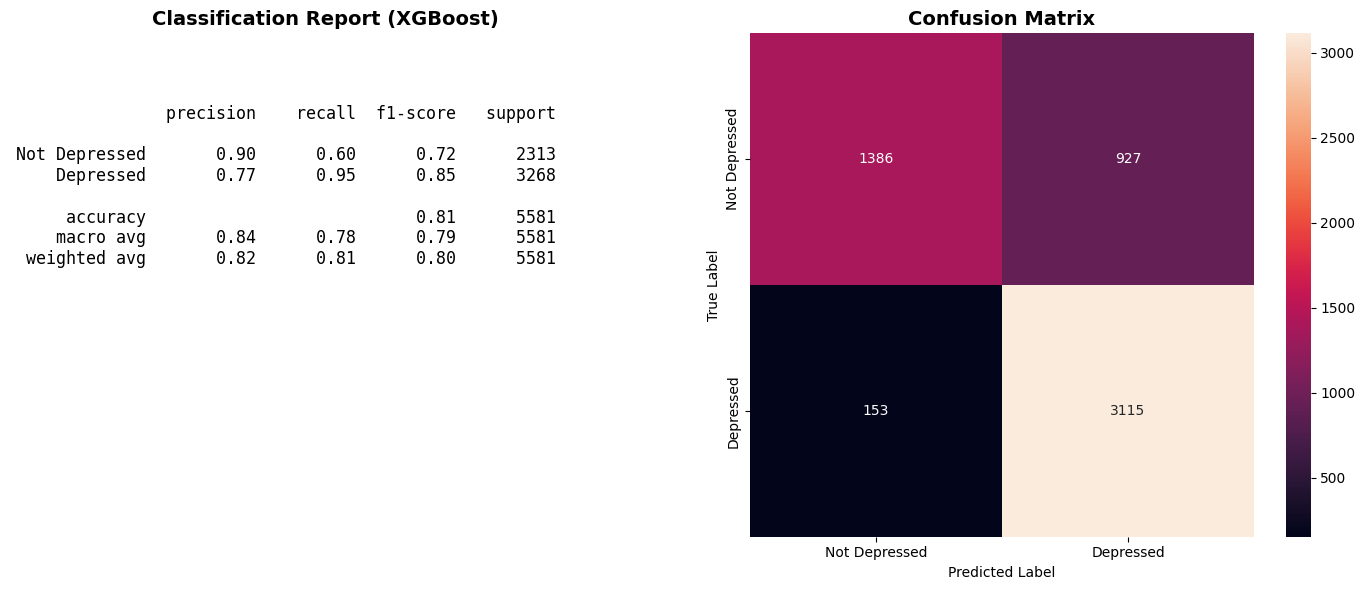

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

best_model = search.best_estimator_

# Dự đoán
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Tạo báo cáo phân loại
target_names = ["Not Depressed", "Depressed"]
report_dict = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
report_text = classification_report(y_test, y_pred, target_names=target_names)

# Tạo ma trận nhầm lẫn
conf_matrix = confusion_matrix(y_test, y_pred)

# Vẽ báo cáo và ma trận nhầm lẫn
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Báo cáo phân loại
ax[0].axis("off")
ax[0].set_title("Classification Report (XGBoost)", fontsize=14, weight="bold")
ax[0].text(0.01, 0.5, report_text, fontsize=12, family="monospace")

# Vẽ ma trận nhầm lẫn
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='rocket', cbar=True,
            xticklabels=target_names, yticklabels=target_names, ax=ax[1])
ax[1].set_title("Confusion Matrix", fontsize=14, weight="bold")
ax[1].set_xlabel("Predicted Label")
ax[1].set_ylabel("True Label")

plt.tight_layout()
plt.show()

Recall lớp Depressed đạt 95%, thể hiện khả năng phát hiện người trầm cảm tốt, phù hợp với mục tiêu không bỏ sót trường hợp. Tuy nhiên, recall lớp Not Depressed chỉ 60%, là trade-off chấp nhận được trong bài toán y tế.

## 7. Vẽ Precision–Recall Curve

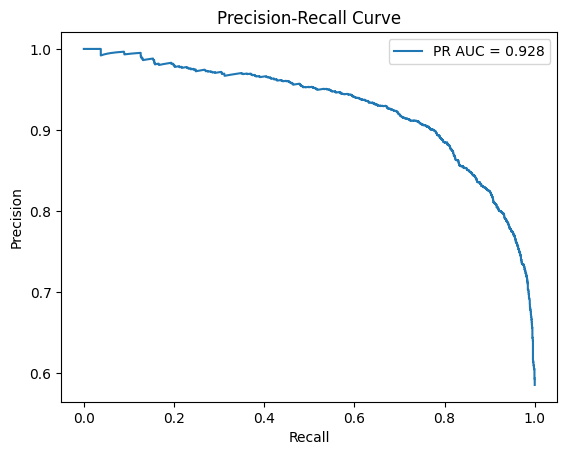

In [44]:
from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)

plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.3f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

PR-AUC = 0.928 cho thấy mô hình có hiệu suất cao trong việc phân biệt hai lớp. Precision giảm dần khi recall tăng, thể hiện trade-off điển hình giữa hai chỉ số này.

## 8. Kiểm tra learning curve

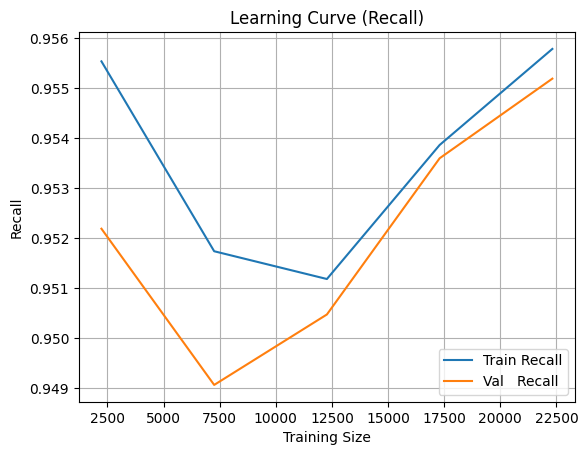

In [45]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y, cv=5, scoring='recall', n_jobs=-1,
    train_sizes=np.linspace(0.1,1.0,5)
)
train_mean = train_scores.mean(axis=1)
test_mean  = test_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label="Train Recall")
plt.plot(train_sizes, test_mean,  label="Val   Recall")
plt.xlabel("Training Size")
plt.ylabel("Recall")
plt.title("Learning Curve (Recall)")
plt.legend()
plt.grid()
plt.show()

Learning Curve (Recall) cho thấy Train Recall và Val Recall rất gần nhau, chứng tỏ mô hình không bị overfitting. Cả hai chỉ số đều cải thiện nhẹ khi tăng dữ liệu huấn luyện, cho thấy mô hình có thể hưởng lợi từ việc mở rộng tập dữ liệu.